# Problem
Say we want to solve the system:

$$
\begin{bmatrix} \ddot{y}_1(t) \\ \ddot{y}_2(t)\end{bmatrix}
+ \begin{bmatrix} -2 & -2  \\ -2 & -2 \end{bmatrix}\begin{bmatrix} y_1(t) \\ y_2(t)\end{bmatrix}
+ \begin{bmatrix} t \\ t^2 \end{bmatrix}
= 0
$$

with $y(0) = 0$, and $y(4) = \begin{bmatrix} 1 \\ -1\end{bmatrix}$. The solution $y(t)$ is the most likely path of a diffusion.

$$
    y(t) = \operatorname{Mode}[X_t | X_4 = y(4)] \\
$$

where $X_t$ is the solution to the SDE $dX_t = (A(t)X_t + D(t))dt + dW_t$ with $A(t)$ and $D(t)$ the solutions to

$$
\begin{align*}
    A^\top A + \dot{A} &= -\begin{bmatrix} -2 & -2  \\ -2 & -2 \end{bmatrix} \\
    \dot{D} + A^\top D &= -\begin{bmatrix} t \\ t^2 \end{bmatrix}
\end{align*}
$$

In this case we have:

$$
\begin{align*}
    A(t) &= \begin{bmatrix} 1 & 1 \\ 1 & 1 \end{bmatrix} \\
    D(t) &= \begin{bmatrix} 
                \frac{c_1}{2}e^{-2t}(e^{2t}+1)-\frac{c_2}{2}e^{-2t}(e^{2t}-1)+\frac{1}{6}(t-3)t^2
                \\
                -\frac{c_1}{2}e^{-2t}(e^{2t}-1)+\frac{c_2}{2}e^{-2t}(e^{2t}+1)-\frac{t^3}{6}
            \end{bmatrix} 
\end{align*}
$$

We can simulate this with the Euler-Maruyama method. However, if we want to force $X_1 = y(1)$ then we need an SDE for the diffusion bridge. Let $X_{t}^{(b)}$ be the diffusion bridge, then its dynamics are described by:

$$
 dX_{t}^{(b)} = \left(A(t)X_{t}^{(b)} + D(t) + \frac{(y(4)-\mu(T,X_{t}^{(b)},t))\Phi_{t,1}}{\Sigma(1,X_{t}^{(b)},t)}\right) + dW_{t}
$$

where,

$$
\begin{align*}
    \Phi_{a,b} &= \exp\left(\int_{a}^{b} A(u)du\right) \\
    \mu(T,x,t) &= \mathbb{E}\Big[X_{T}\Big|X_{t}=x\Big] \\
    \Sigma(T,x,t) &= \operatorname{Var}\Big(X_{T}\Big|X_{t}=x\Big) \\
\end{align*}
$$

In [1]:
import numpy as np
from solvers import DiffusionODESolver

def A(t):
    return np.ones((2,2))

def D(t):
    #constants can be set to zero
    d1 = (t - 3) * t**2 / 6
    d2 = -t**3 / 6
    return np.array([[d1],[d2]])

def phi(a,b):
    x = np.exp(2*(b - a))
    return np.array([[x+1,x-1],[x-1,x+1]]) / 2


solver = DiffusionODESolver(A=A, D=D, T=4, yT=np.array([1,-1]), phi=phi)
t,y = solver.solve(npoints=100)

## Plot approximation and error

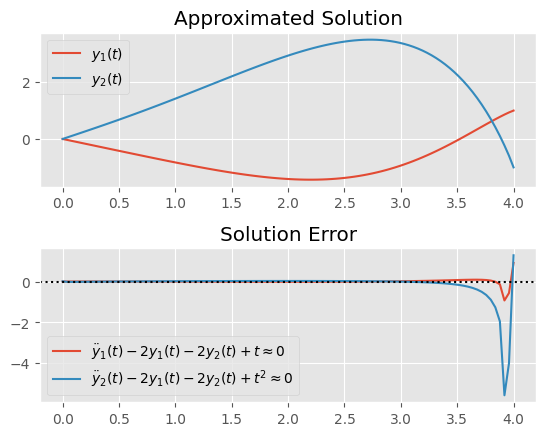

In [2]:
from utils import calc_error
import matplotlib.pyplot as plt
plt.style.use('ggplot')

fig,axs = plt.subplots(2, gridspec_kw={'hspace':.4})

# plot approximation
axs[0].plot(t, y.T, label=['$y_1(t)$','$y_2(t)$'])
axs[0].set_title('Approximated Solution')
axs[0].legend()

# plot error
g = lambda t: -2*np.ones((2,2))
h = lambda t: np.array([t, t**2])

labels = [
    '$\ddot{y}_1(t)-2y_1(t)-2y_2(t)+t\\approx0$',
    '$\ddot{y}_2(t)-2y_1(t)-2y_2(t)+t^2\\approx0$'
]
axs[1].plot(t, calc_error(y, t, g=g, h=h).T, label=labels)
axs[1].axhline(0, ls=':', c='k')
axs[1].set_title('Solution Error')
axs[1].legend()
plt.show()

## Non-zero $\dot{y}(t)$ coefficient (TODO: NOT ACCURATE)
Let's solve a similar system that includes a $\dot{y}(t)$ term.

$$
\begin{bmatrix} \ddot{y}_1(t) \\ \ddot{y}_2(t)\end{bmatrix}
+ \begin{bmatrix} -1 & -1  \\ -1 & -1 \end{bmatrix}\begin{bmatrix} \dot{y}_1(t) \\ \dot{y}_2(t)\end{bmatrix}
+ \begin{bmatrix} -2 & -2  \\ -2 & -2 \end{bmatrix}\begin{bmatrix} y_1(t) \\ y_2(t)\end{bmatrix}
+ \begin{bmatrix} t \\ t^2 \end{bmatrix}
= 0
$$

with $y(0) = 0$ and, $y(4) = \begin{bmatrix} 1 \\ -1\end{bmatrix}$. Now the solution $y(t)$ is the most likely path of a diffusion.

$$
    y(t) = e^{-V(t)}\operatorname{Mode}[X_t | X_4 = y(4)] \\
$$

where $V(t)=2^{-1}\int_{t}^{T}\begin{bmatrix} -1 & -1  \\ -1 & -1 \end{bmatrix}ds=(t-T)\begin{bmatrix} .5 & .5 \\ .5 & .5 \end{bmatrix}$ and $X_t$ is the solution to the SDE $dX_t = (A(t)X_t + D(t))dt + dW_t$. The definitions of $A(t)$ and $D(t)$ have to be modified; define $\hat{g}(t)$ and $\hat{h}(t)$ as

$$
\begin{align*}
\hat{g}(t)&:=-\ddot{V}(t)+\dot{V}^2(t)-\begin{bmatrix} -1 & -1  \\ -1 & -1 \end{bmatrix}\dot{V}(t)+\begin{bmatrix} -2 & -2  \\ -2 & -2 \end{bmatrix} = \begin{bmatrix} -.5 & -.5 \\ -.5 & -.5 \end{bmatrix}\\
\hat{h}(t)&:=e^{-V(t)}\begin{bmatrix} t \\ t^2 \end{bmatrix} = \frac{1}{2}\begin{bmatrix} e^{T-t}+1 & e^{T-t}-1 \\ e^{T-t}-1 & e^{T-t}+1 \end{bmatrix}\begin{bmatrix} t \\ t^2 \end{bmatrix}
\end{align*}
$$

Now $A(t)$ and $D(t)$ are the solutions to the following system.

$$
\begin{align*}
    A^\top A + \dot{A} &= -\hat{g}(t) \\
    \dot{D} + A^\top D &= -\hat{h}(t)
\end{align*}
$$

In this case we have:

$$
\begin{align*}
    A(t) &= \begin{bmatrix} .5 & .5 \\ .5 & .5 \end{bmatrix} \\
    D(t) &= c_1e^{-t}-\frac{t^3}{6}\begin{bmatrix} e^{1-t}+1 \\ e^{1-t}-1 \end{bmatrix}-\frac{t^2}{4}\begin{bmatrix} e^{1-t}-1 \\ e^{1-t}+1 \end{bmatrix}+\frac{c_2}{12}\begin{bmatrix} -1 \\ 1 \end{bmatrix}
\end{align*}
$$

Like the previous problem, we can then find a diffusion bridge to estimate the solution $y(t)$.

In [3]:
def A2(t):
    return .5*np.ones((2,2))

def D2(t):
    #constants can be set to zero
    x = np.exp(4-t)
    d1 = -np.array([[x+1],[x-1]]) * t**3 / 6
    d2 = -np.array([[x-1],[x+1]]) * t**2 / 4
    return d1 + d2

def V(t):
    return (t - 4) * .5*np.ones((2,2))

def phi2(a,b):
    x = np.exp(b - a)
    return np.array([[x+1,x-1],[x-1,x+1]]) / 2


solver2 = DiffusionODESolver(T=4, yT=np.array([1,-1]), A=A2, D=D2, V=V, phi=phi2)
t2,y2 = solver2.solve(npoints=100)

## Plot approximation and error

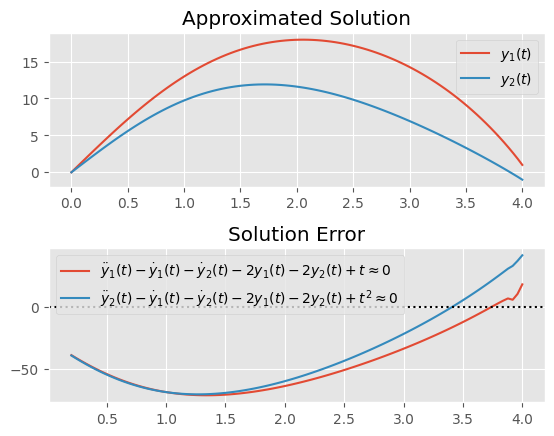

In [4]:
fig,axs = plt.subplots(2, gridspec_kw={'hspace':.4})

# plot approximation
axs[0].plot(t2, y2.T, label=['$y_1(t)$','$y_2(t)$'])
axs[0].set_title('Approximated Solution')
axs[0].legend()

# plot error
g2 = lambda t: -2*np.ones((2,2))
f2 = lambda t: -np.ones((2,2))
h2 = lambda t: np.array([t, t**2])
labels2 = [
    '$\ddot{y}_1(t)-\dot{y}_1(t)-\dot{y}_2(t)-2y_1(t)-2y_2(t)+t\\approx0$',
    '$\ddot{y}_2(t)-\dot{y}_1(t)-\dot{y}_2(t)-2y_1(t)-2y_2(t)+t^2\\approx0$'
]
axs[1].plot(t2[5:], calc_error(y2, t2, g=g2, f=f2, h=h2).T[5:], label=labels2)
axs[1].axhline(0, ls=':', c='k')
axs[1].set_title('Solution Error')
axs[1].legend()